导入包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False #正常显示负号

# 多种proxy制图

In [2]:
#定义全局变量，坐标轴标签、刻度等可在此修改
global X_LABEL
global Y_LABEL
global X_MIN
global X_MAX
global X_INTERVAL
global Y_MIN
global Y_MAX
global Y_INTERVAL

X_LABEL = "Age (millions of years ago)"
Y_LABEL = "Atmospheric CO2 (ppm)"
X_MIN = 0
X_MAX = 71
X_INTERVAL = 5
Y_MIN = 0
Y_MAX = 10001
Y_INTERVAL = 1000

#定义映射
proxy_dict = {'Boron Proxies': 'darkorange', 'Land Plant 𝛿¹³C' : 'royalblue', 'Leaf Gas Exchange' : 'forestgreen', 'Liverworts' : 'turquoise',
             'Nahcolite' : 'indigo', 'Paleosols' : 'blueviolet', 'Phytoplankton' : 'brown', 'Stomatal Frequencies' : 'gold'}

In [3]:
#定义绘图函数
def draw(proxy, dataframe):
        #设置坐标轴标签
        plt.xlabel(X_LABEL)
        plt.ylabel(Y_LABEL)
        #设置坐标轴范围及刻度
        plt.xlim(X_MIN,X_MAX)
        plt.xticks(range(X_MIN,X_MAX,X_INTERVAL))
        plt.ylim(Y_MIN,Y_MAX)
        plt.yticks(range(Y_MIN,Y_MAX,Y_INTERVAL))
        #反转x轴
        plt.gca().invert_xaxis()
        count=1
        for i in proxy:
            df = dataframe[dataframe['proxy']==i]
            plt.errorbar(df['age'],df['co2'],
                        xerr=(df['age_uncertainty_younger'],df['age_uncertainty_older']),
                        yerr=(df['co2_uncertainty_lower'],df['co2_uncertainty_higher']),
                        label=i,
                        fmt=',',
                        color='gray',
                        linewidth=1,
                        alpha=0.5,
                        zorder=1)
    
            plt.scatter(df['age'],df['co2'],
                        s=5,
                        label=i,
                        color=proxy_dict[i],
                        zorder=count)
            count=count+1
            
        plt.show()

In [4]:
#读取数据
df = pd.read_csv('age_co2_plot_data.csv',keep_default_na=True)

#单位处理
df['age'] = df['age']/1000
df['age_uncertainty_younger']=df['age_uncertainty_younger']/1000
df['age_uncertainty_older']=df['age_uncertainty_older']/1000

#分别筛选各个proxy
proxy = ['Boron Proxies','Land Plant 𝛿¹³C','Leaf Gas Exchange','Liverworts','Nahcolite','Paleosols','Phytoplankton','Stomatal Frequencies']
proxy2=['Nahcolite']

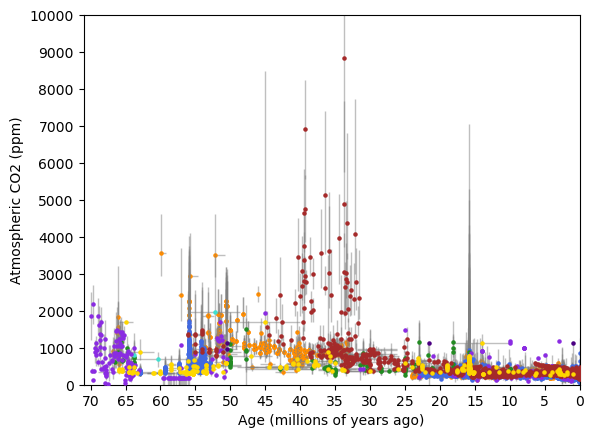

In [5]:
#绘制散点图
draw(proxy,df)

# 论文制图

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import matplotlib.dates as mdates
import numpy as np
from loess.loess_1d import loess_1d
%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False #正常显示负号

In [13]:
#散点图绘制
def draw_scatter(ax,age,co2,label,color,zorder,s=5,
                 errorbar=False,
                 xerr=(0,0),yerr=(0,0),
                 err_fmt=',',
                 err_color='gray',
                 err_linewidth=1,
                 err_alpha=0.5,
                capsize=0):
        if errorbar == False:
            ax.scatter(age,co2,label=label,color=color,s=s,zorder=zorder)
        else:
            ax.scatter(age,co2,label=label,color=color,s=s,zorder=zorder)
            ax.errorbar(age,co2,
                       yerr=yerr,
                       xerr=xerr,
                       fmt=err_fmt,
                       color=err_color,
                       linewidth=err_linewidth,
                       alpha=err_alpha,
                       capsize=capsize,
                       zorder=1)
        plt.show()
        
#误差阴影图绘制
def draw_shadowband(ax,age,co2,label,color,zorder,linewidth=2,yerr_low=0,yerr_high=0,shadow_color='gray',shadow_alpha=0.8):
       ax.fillbetween(age,co2,yerr_low,yerr_high,color=shadow_color,alpha=shadow_alpha)
       ax.plot(age,co2,label=label,color=color,linewidth=linewidth,zorder=zorder)

In [18]:
df = pd.read_excel("new_data.xlsx",sheet_name="Sheet2",usecols="C:F,H:I" )
df.head()

,age,age_old,age_young,co2,co2_low,co2_high
0,130.1,130.8,129.4,1171.000000,585.500000,2342.000000
1,130.2,NaN,NaN,273.335226,136.667613,546.670453
2,130.8,NaN,NaN,369.900906,184.950453,739.801812
3,131.3,NaN,NaN,189.800310,94.900155,379.600620
4,132.0,NaN,NaN,132.020419,66.010210,264.040838


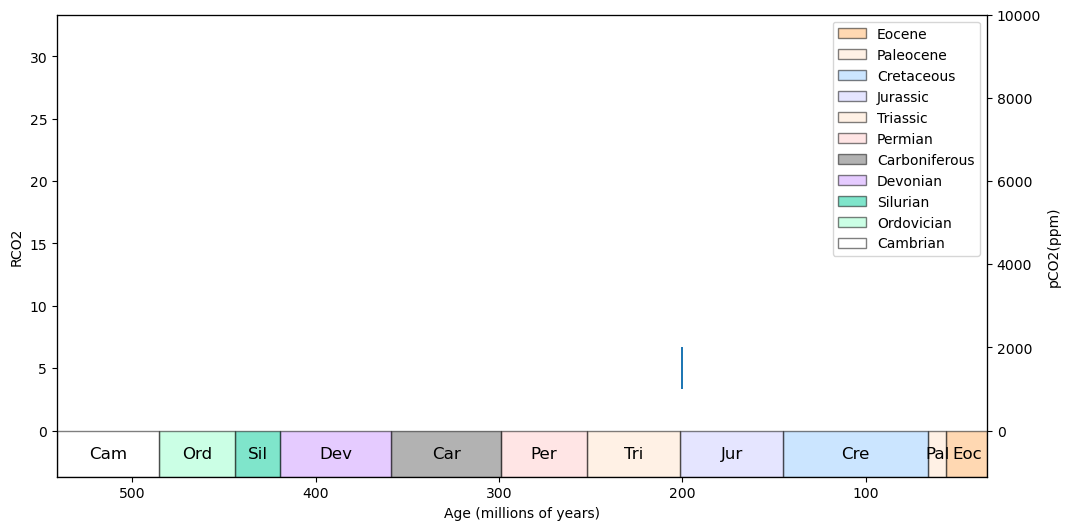

In [21]:
# Define the geological time scale and corresponding colors
geological_timescale = {
#     'Holocene': (0, 0.0117, (0, 180, 0)),
#     'Pleistocene': (0.0117, 2.58, (255, 255, 178)),
#     'Pliocene': (2.58, 5.333, (255, 200, 87)),
#     'Miocene': (5.333, 23.03, (192, 0, 0)),
#     'Oligocene': (23.03, 33.9, (255, 204, 153)),
    'Eocene': (33.9, 56, (255, 178, 102)),
    'Paleocene': (56, 66, (255, 229, 204)),
    'Cretaceous': (66, 145, (153, 204, 255)),
    'Jurassic': (145, 201.3, (204, 204, 255)),
    'Triassic': (201.3, 252.17, (255, 229, 204)),
    'Permian': (252.17, 298.9, (255, 204, 204)),
    'Carboniferous': (298.9, 358.9, (102, 102, 102)),
    'Devonian': (358.9, 419.2, (204, 153, 255)),
    'Silurian': (419.2, 443.8, (0, 204, 153)),
    'Ordovician': (443.8, 485.4, (153, 255, 204)),
    'Cambrian': (485.4, 541, (255, 255, 255))
}

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Set the x-axis to a logarithmic scale and adjust the limits
# ax.set_xscale('log')
ax.set_xlim(33.9, 541)
#y轴范围
ymax=10000
ymax2=ymax/300 

ax.set_ylim(-ymax2/9,ymax2)
ax.invert_xaxis()
ax2 = ax.twinx()
ax2.set(
    ylim=(-1,9),
    yticks=([])
)
# Loop through the geological time scale and plot each time period with a different color
for time_period, age_range_color in geological_timescale.items():
    ax2.axvspan(age_range_color[0], age_range_color[1],ymin = 0, ymax = 0.1, alpha=0.5, facecolor=(age_range_color[2][0]/255, age_range_color[2][1]/255, age_range_color[2][2]/255), label=time_period, edgecolor = 'k')
    # Add the abbreviated name of each time period to the plot below the x-axis
    ax2.text((age_range_color[0]+age_range_color[1])/2, -0.5, time_period[:3], ha='center', va='center', fontsize=12, color='black')

# Add a legend and axis labels
ax2.legend(loc='upper right')
ax.set_xlabel('Age (millions of years)')
ax.set_ylabel('RCO2')
ax3=ax.twinx()
ax3.set(
    ylim=(-ymax/9,ymax),
    ylabel='pCO2(ppm)'
)
# Show the plot




# ax3.fill_between(df['age'],df['co2_low'],df['co2_high'],facecolor='gray',alpha=0.8,linewidth=0)
# ax3.plot(df['age'],df['co2'],linewidth=2)

# draw_scatter(ax3,df['age'],df['co2'],label='paleosol',color='r',zorder=2,
#              errorbar=True,
#              xerr=(df['age']-df['age_young'],df['age_old']-df['age']),
#              yerr=(df['co2']-df['co2_low'],df['co2_high']-df['co2']),
#             )
# print(max(df['co2_high']))

# df1 = df[df['age']>=310]
# xarray=df1['age'].values
# yarray=df1['co2'].values
# print(xarray)


#长条图
ax3.bar(200,1000,1,1000)



plt.show()

In [15]:
plt.show()

## PyGplates

In [41]:
import requests
import json

featurecollection= {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[-66.96399527778121,0.08480498968637591,-1.041251881730811e-9]}},{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[-50.26742644744623,-9.131305457215065,-4.012530655510278e-9]}},{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[-86.4606199362609,35.87971530053026,-1.3183746082831785e-9]}},{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[-66.3889696082647,-1.7006566507389476,4.166627807583027e-9]}},{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[-76.26884029698192,23.81019827148597,-8.34300781934006e-9]}},{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[-78.03146874799945,-2.8310182489749685,0]}}]}

formdata = {
    "feature_collection": featurecollection,
    "time": "250",
    "model": "SCOTESE&WRIGHT2018"
}


# headers = {
#     "content-type": "multipart/form-data; boundary=----WebKitFormBoundary7MA4YWxkTrZu0gW"
# }

r = requests.post("https://deep-time.org/reconstruct/reconstruct_feature_collection", params=formdata)
print(r)



<Response [400]>
